Random Forest Classification Report:
              precision    recall  f1-score   support

 Brute Force       1.00      0.87      0.93       532
     Malware       0.98      0.89      0.93        64
      Normal       1.00      1.00      1.00     19954
  Probe/Scan       1.00      1.00      1.00      1994

    accuracy                           1.00     22544
   macro avg       0.99      0.94      0.97     22544
weighted avg       1.00      1.00      1.00     22544

Random Forest Accuracy: 0.9965400993612491

SVM Classification Report:
              precision    recall  f1-score   support

 Brute Force       1.00      0.95      0.98       532
     Malware       1.00      0.92      0.96        64
      Normal       1.00      1.00      1.00     19954
  Probe/Scan       1.00      0.99      1.00      1994

    accuracy                           1.00     22544
   macro avg       1.00      0.97      0.98     22544
weighted avg       1.00      1.00      1.00     22544

SVM Accuracy: 0.998092

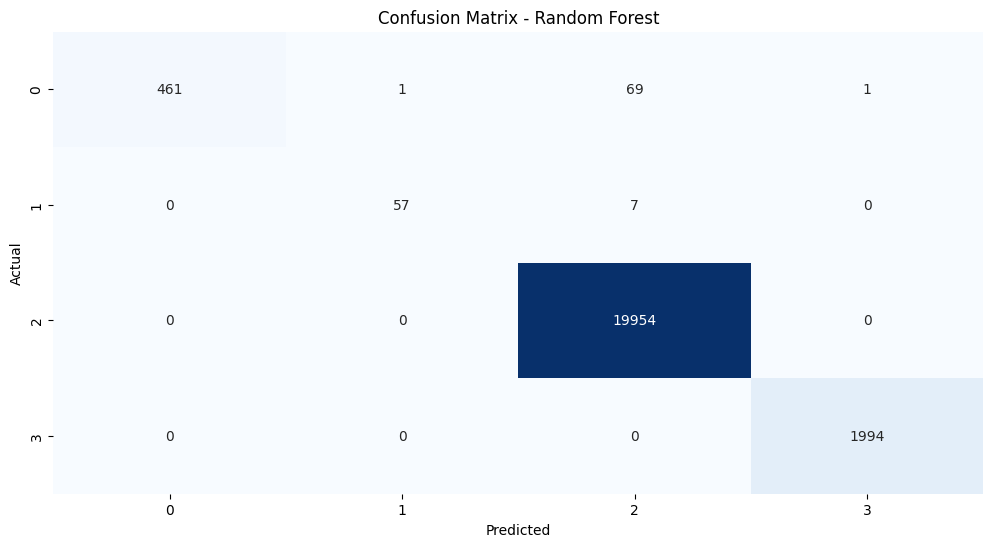

In [3]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
train_path = 'D:/nids/Train_data.csv'
test_path = 'D:/nids/Test_data.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Data Preprocessing
def preprocess_data(train, test):
    # Drop missing values
    train.dropna(inplace=True)
    test.dropna(inplace=True)

    # Convert categorical to numerical
    label_encoder = LabelEncoder()
    for col in train.select_dtypes(include=['object']).columns:
        train[col] = label_encoder.fit_transform(train[col])

    for col in test.select_dtypes(include=['object']).columns:
        test[col] = label_encoder.fit_transform(test[col])

    # Ensure same features in train and test
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]

    # Feature scaling
    scaler = StandardScaler()
    train.iloc[:, :-1] = scaler.fit_transform(train.iloc[:, :-1])
    test.iloc[:, :-1] = scaler.transform(test.iloc[:, :-1])

    return train, test

train_data, test_data = preprocess_data(train_data, test_data)

# Feature and Target Separation
X_train = train_data.iloc[:, :-1]
X_test = test_data.iloc[:, :-1]

# Define Attack Category based on threshold conditions
def assign_attack_category(row):
    if row['num_failed_logins'] > 2 or row['root_shell'] > 0:
        return 'Brute Force'
    elif row['count'] > 500 and row['same_srv_rate'] > 0.8:
        return 'DoS'
    elif row['dst_host_srv_count'] < 5 and row['diff_srv_rate'] > 0.9:
        return 'Probe/Scan'
    elif row['num_compromised'] > 2 and row['su_attempted'] > 0:
        return 'U2R'
    elif row['num_shells'] > 0 or row['num_access_files'] > 2:
        return 'Malware'
    else:
        return 'Normal'

train_data['attack_category'] = train_data.apply(assign_attack_category, axis=1)
test_data['attack_category'] = test_data.apply(assign_attack_category, axis=1)

y_train = train_data['attack_category']
y_test = test_data['attack_category']

# Model Training: Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Model Training: SVM
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

# Evaluation
print('Random Forest Classification Report:')
print(classification_report(y_test, rf_pred))
print('Random Forest Accuracy:', accuracy_score(y_test, rf_pred))

print('\nSVM Classification Report:')
print(classification_report(y_test, svm_pred))
print('SVM Accuracy:', accuracy_score(y_test, svm_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
